In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import utils, Modelling, dataset_module, Train_Test


In [2]:
class ModelEvaluator:
    
    def __init__(self, input_dataset, trainset,  model):

        assert isinstance(input_dataset, pd.DataFrame)
        assert isinstance(trainset, dataset_module.DataSetForImputation)
        assert isinstance(model, Modelling.DenoisingAutoEncoder)

        RANDOM_SEED = 18
        np.random.seed(RANDOM_SEED)
        if torch.cuda.is_available():
            device = 'cuda'
            torch.cuda.manual_seed(RANDOM_SEED)
            torch.set_default_tensor_type(torch.cuda.FloatTensor)
            kwargs = {'num_workers': 4, 'pin_memory': True}
        else:
            device = 'cpu'
            torch.manual_seed(RANDOM_SEED)
            torch.set_default_tensor_type(torch.FloatTensor)
            kwards = {}

        self.complete_dataset = input_dataset.copy() # No NaNs

        self.sampled_dataset, _ = train_test_split(self.complete_dataset, test_size = 0.1) # 90% of the complete dataset is used
        self.dataset_for_models = self.sampled_dataset.copy()  # introduce NaNs here
        self.dataset_for_models = utils.induce_missingness(self.dataset_for_models) # half the variables, 20% missing data

        self.model = model.eval()
        self.evaluated_dataset = Train_Test.test_model(net=self.model, test_df=self.dataset_for_models,
                                                       trainset=trainset, device=device,
                                                       logger_level=20) # All NaNs filled (only imputed values are filled)
    @staticmethod
    def fitter(dataframe):
        """Fit a Linear Regression model using all variables of the dataframe

        Returns all the co-efficients
        """
        assert isinstance(dataframe, pd.DataFrame)

        from sklearn.linear_model import LinearRegression

        fitting_model = LinearRegression().fit(dataframe.iloc[:, :-1], dataframe.iloc[:,-1])
        co_eff = fitting_model.coef_
        co_eff = (co_eff - co_eff.min()) / (co_eff.max() - co_eff.min())
        return co_eff

    def plot_evaluation(self, data_to_be_compared = None, title = None, xlabel = "Regression params from Imputed data", annotation = True):
        
        y = ModelEvaluator.fitter(self.complete_dataset)
        x = ModelEvaluator.fitter(data_to_be_compared)

        import matplotlib.pyplot as plt
        fig, ax = plt.subplots()
        ax.set_title(title)
        ax.set_ylabel("Regression params from Original data")
        ax.set_xlabel(xlabel)
        plt.scatter(x, y, label = "Parameter comparison")
        if annotation:
            plt.annotate(title.split()[-1], xy=(0.1, 0.9), xycoords='axes fraction') #Dataset
        
        lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
                np.max([ax.get_xlim(), ax.get_ylim()])] # max of both axes
        
        # now plot both limits against eachother
        ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)

        plt.show()


INFO:root:Input filename has to be space separated data
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 11.56
INFO:root: Returning train_df, test_df, full_test_df after splitting dataframe in 0.7/0.3 split 
INFO:root: Note: full_test_df is the same as test_df but without NaNs
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 11.76


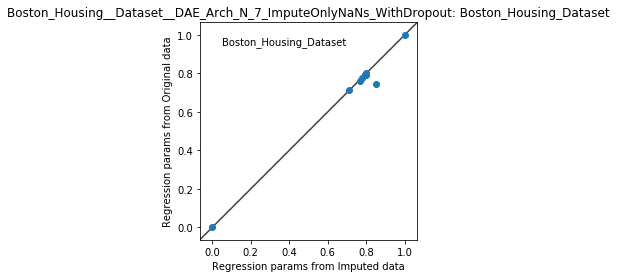

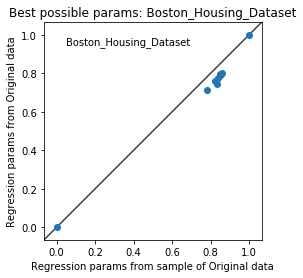

In [4]:
# Boston
# 1
if __name__ == '__main__':
    
    #Provide Dataset
    filename = "data/boston_housing/boston_housing.csv"
    
    #Check df
    df = utils.get_dataframe_from_csv(filename, header_row=0, sep=',')
    train_df, test_df, full_test_df = utils.create_train_test_split(dataframe=df.copy(), test_perc=0.3, logger_level=20) # full_test_df is test_df but has no NaNs
    input_dataset = full_test_df
    trainset = dataset_module.DataSetForImputation(train_df, normalize=True)  # normalize True for [0,1] normalization for dataframe

    #Provide Model Name
    model_name = "Boston_Housing__Dataset__DAE_Arch_N_7_ImputeOnlyNaNs_WithDropout"
    
    #Provide Model Details
    model = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta=7, input_dropout=0.5)
    #Provide Saved location
    model.load_state_dict(torch.load(f"./Results/boston_results/{model_name}/artifacts/saved_model/model_at_epoch100"))
    
    #Print Details
    model_eval = ModelEvaluator(input_dataset, trainset,  model)
    model_eval.plot_evaluation(title = model_name+": Boston_Housing_Dataset", data_to_be_compared = model_eval.evaluated_dataset, xlabel = "Regression params from Imputed data" )
    model_eval.plot_evaluation(title ="Best possible params:"+" Boston_Housing_Dataset", data_to_be_compared = model_eval.sampled_dataset, xlabel = "Regression params from sample of Original data" )    

INFO:root:Input filename has to be space separated data
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 11.56
INFO:root: Returning train_df, test_df, full_test_df after splitting dataframe in 0.7/0.3 split 
INFO:root: Note: full_test_df is the same as test_df but without NaNs
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 11.76


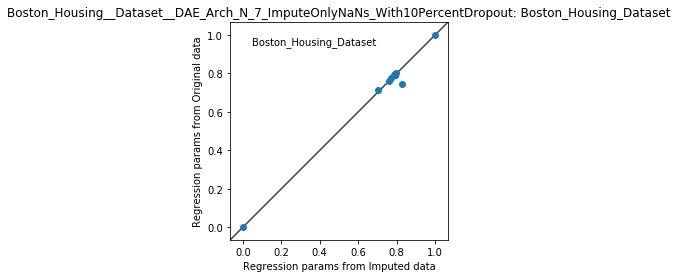

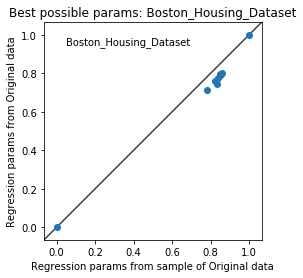

In [5]:
# Boston
# 2
if __name__ == '__main__':
    
    #Provide Dataset
    filename = "data/boston_housing/boston_housing.csv"
    
    #Check df
    df = utils.get_dataframe_from_csv(filename, header_row=0, sep=',')
    train_df, test_df, full_test_df = utils.create_train_test_split(dataframe=df.copy(), test_perc=0.3, logger_level=20) # full_test_df is test_df but has no NaNs
    input_dataset = full_test_df
    trainset = dataset_module.DataSetForImputation(train_df, normalize=True)  # normalize True for [0,1] normalization for dataframe

    #Provide Model Name
    model_name = "Boston_Housing__Dataset__DAE_Arch_N_7_ImputeOnlyNaNs_With10PercentDropout"
    
    #Provide Model Details
    model = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta=7, input_dropout=0.1)
    #Provide Saved location
    model.load_state_dict(torch.load(f"./Results/boston_results/{model_name}/artifacts/saved_model/model_at_epoch100"))
    
    #Print Details
    model_eval = ModelEvaluator(input_dataset, trainset,  model)
    model_eval.plot_evaluation(title = model_name+": Boston_Housing_Dataset", data_to_be_compared = model_eval.evaluated_dataset, xlabel = "Regression params from Imputed data" )
    model_eval.plot_evaluation(title ="Best possible params:"+" Boston_Housing_Dataset", data_to_be_compared = model_eval.sampled_dataset, xlabel = "Regression params from sample of Original data" )    

INFO:root:Input filename has to be space separated data
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 11.56
INFO:root: Returning train_df, test_df, full_test_df after splitting dataframe in 0.7/0.3 split 
INFO:root: Note: full_test_df is the same as test_df but without NaNs
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 11.76


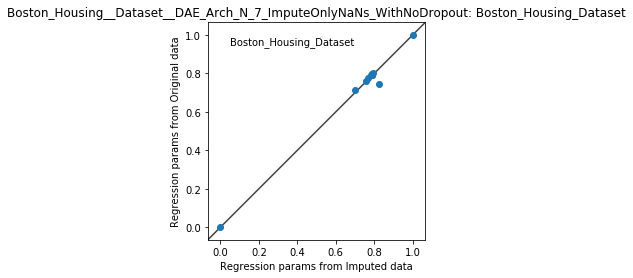

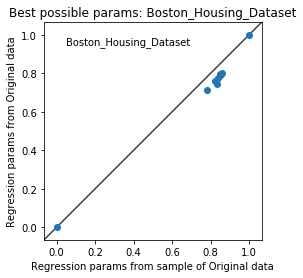

In [6]:
# Boston
# 3
if __name__ == '__main__':
    
    #Provide Dataset
    filename = "data/boston_housing/boston_housing.csv"
    
    #Check df
    df = utils.get_dataframe_from_csv(filename, header_row=0, sep=',')
    train_df, test_df, full_test_df = utils.create_train_test_split(dataframe=df.copy(), test_perc=0.3, logger_level=20) # full_test_df is test_df but has no NaNs
    input_dataset = full_test_df
    trainset = dataset_module.DataSetForImputation(train_df, normalize=True)  # normalize True for [0,1] normalization for dataframe

    #Provide Model Name
    model_name = "Boston_Housing__Dataset__DAE_Arch_N_7_ImputeOnlyNaNs_WithNoDropout"
    
    #Provide Model Details
    model = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta=7, input_dropout=0.0)
    #Provide Saved location
    model.load_state_dict(torch.load(f"./Results/boston_results/{model_name}/artifacts/saved_model/model_at_epoch100"))
    
    #Print Details
    model_eval = ModelEvaluator(input_dataset, trainset,  model)
    model_eval.plot_evaluation(title = model_name+": Boston_Housing_Dataset", data_to_be_compared = model_eval.evaluated_dataset, xlabel = "Regression params from Imputed data" )
    model_eval.plot_evaluation(title ="Best possible params:"+" Boston_Housing_Dataset", data_to_be_compared = model_eval.sampled_dataset, xlabel = "Regression params from sample of Original data" )    

INFO:root:Input filename has to be space separated data
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 11.56
INFO:root: Returning train_df, test_df, full_test_df after splitting dataframe in 0.7/0.3 split 
INFO:root: Note: full_test_df is the same as test_df but without NaNs
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 11.76


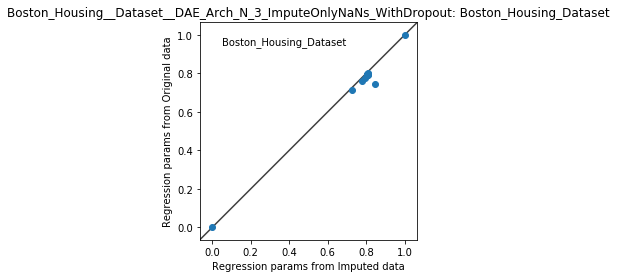

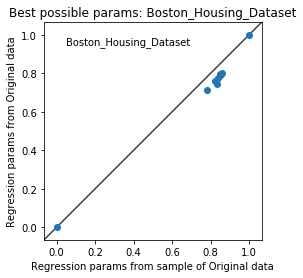

In [7]:
# Boston
# 4
if __name__ == '__main__':
    
    #Provide Dataset
    filename = "data/boston_housing/boston_housing.csv"
    
    #Check df
    df = utils.get_dataframe_from_csv(filename, header_row=0, sep=',')
    train_df, test_df, full_test_df = utils.create_train_test_split(dataframe=df.copy(), test_perc=0.3, logger_level=20) # full_test_df is test_df but has no NaNs
    input_dataset = full_test_df
    trainset = dataset_module.DataSetForImputation(train_df, normalize=True)  # normalize True for [0,1] normalization for dataframe

    #Provide Model Name
    model_name = "Boston_Housing__Dataset__DAE_Arch_N_3_ImputeOnlyNaNs_WithDropout"
    
    #Provide Model Details
    model = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta=3, input_dropout=0.5)
    #Provide Saved location
    model.load_state_dict(torch.load(f"./Results/boston_results/{model_name}/artifacts/saved_model/model_at_epoch100"))
    
    #Print Details
    model_eval = ModelEvaluator(input_dataset, trainset,  model)
    model_eval.plot_evaluation(title = model_name+": Boston_Housing_Dataset", data_to_be_compared = model_eval.evaluated_dataset, xlabel = "Regression params from Imputed data" )
    model_eval.plot_evaluation(title ="Best possible params:"+" Boston_Housing_Dataset", data_to_be_compared = model_eval.sampled_dataset, xlabel = "Regression params from sample of Original data" )    

INFO:root:Input filename has to be space separated data
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 11.56
INFO:root: Returning train_df, test_df, full_test_df after splitting dataframe in 0.7/0.3 split 
INFO:root: Note: full_test_df is the same as test_df but without NaNs
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 11.76


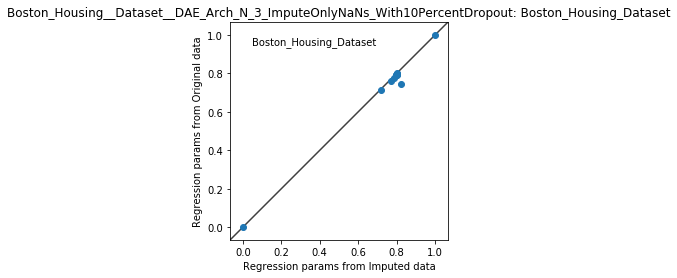

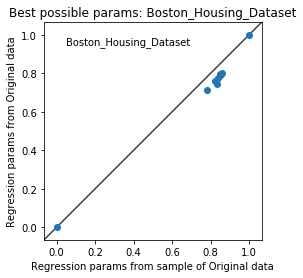

In [8]:
# Boston
# 5
if __name__ == '__main__':
    
    #Provide Dataset
    filename = "data/boston_housing/boston_housing.csv"
    
    #Check df
    df = utils.get_dataframe_from_csv(filename, header_row=0, sep=',')
    train_df, test_df, full_test_df = utils.create_train_test_split(dataframe=df.copy(), test_perc=0.3, logger_level=20) # full_test_df is test_df but has no NaNs
    input_dataset = full_test_df
    trainset = dataset_module.DataSetForImputation(train_df, normalize=True)  # normalize True for [0,1] normalization for dataframe

    #Provide Model Name
    model_name = "Boston_Housing__Dataset__DAE_Arch_N_3_ImputeOnlyNaNs_With10PercentDropout"
    
    #Provide Model Details
    model = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta=3, input_dropout=0.1)
    #Provide Saved location
    model.load_state_dict(torch.load(f"./Results/boston_results/{model_name}/artifacts/saved_model/model_at_epoch100"))
    
    #Print Details
    model_eval = ModelEvaluator(input_dataset, trainset,  model)
    model_eval.plot_evaluation(title = model_name+": Boston_Housing_Dataset", data_to_be_compared = model_eval.evaluated_dataset, xlabel = "Regression params from Imputed data" )
    model_eval.plot_evaluation(title ="Best possible params:"+" Boston_Housing_Dataset", data_to_be_compared = model_eval.sampled_dataset, xlabel = "Regression params from sample of Original data" )    

INFO:root:Input filename has to be space separated data
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 11.56
INFO:root: Returning train_df, test_df, full_test_df after splitting dataframe in 0.7/0.3 split 
INFO:root: Note: full_test_df is the same as test_df but without NaNs
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 11.76


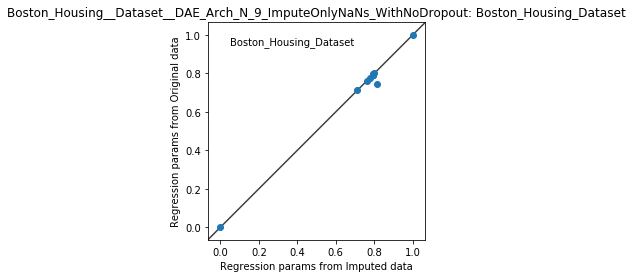

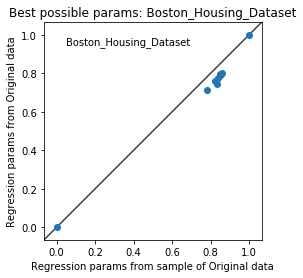

In [9]:
# Boston
# 6
if __name__ == '__main__':
    
    #Provide Dataset
    filename = "data/boston_housing/boston_housing.csv"
    
    #Check df
    df = utils.get_dataframe_from_csv(filename, header_row=0, sep=',')
    train_df, test_df, full_test_df = utils.create_train_test_split(dataframe=df.copy(), test_perc=0.3, logger_level=20) # full_test_df is test_df but has no NaNs
    input_dataset = full_test_df
    trainset = dataset_module.DataSetForImputation(train_df, normalize=True)  # normalize True for [0,1] normalization for dataframe

    #Provide Model Name
    model_name = "Boston_Housing__Dataset__DAE_Arch_N_9_ImputeOnlyNaNs_WithNoDropout"
    
    #Provide Model Details
    model = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta=9, input_dropout=0.0)
    #Provide Saved location
    model.load_state_dict(torch.load(f"./Results/boston_results/{model_name}/artifacts/saved_model/model_at_epoch100"))
    
    #Print Details
    model_eval = ModelEvaluator(input_dataset, trainset,  model)
    model_eval.plot_evaluation(title = model_name+": Boston_Housing_Dataset", data_to_be_compared = model_eval.evaluated_dataset, xlabel = "Regression params from Imputed data" )
    model_eval.plot_evaluation(title ="Best possible params:"+" Boston_Housing_Dataset", data_to_be_compared = model_eval.sampled_dataset, xlabel = "Regression params from sample of Original data" )    